In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import re

In [2]:
df = pd.read_csv('Datasets/all_users.csv',low_memory=False)

In [3]:
df.head()

,user,appid,hours_forever,name
0,id/flutterdim,268500,"1,466",XCOM 2
1,id/flutterdim,582010,"1,434",Monster Hunter: World
2,id/flutterdim,200510,674,XCOM: Enemy Unknown
3,id/flutterdim,262060,578,Darkest Dungeon®
4,id/flutterdim,544750,516,SOULCALIBUR VI


In [4]:
df.shape

(3483068, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3483068 entries, 0 to 3483067
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user           object
 1   appid          int64 
 2   hours_forever  object
 3   name           object
dtypes: int64(1), object(3)
memory usage: 106.3+ MB


In [7]:
## Converting the hours forever datatype to float
df['hours_forever'] = df['hours_forever'].astype('object')

df['hours_forever'] = df['hours_forever'].apply(lambda x: float(str(x).replace(',','').strip()))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3483068 entries, 0 to 3483067
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user           object 
 1   appid          int64  
 2   hours_forever  float64
 3   name           object 
dtypes: float64(1), int64(1), object(2)
memory usage: 106.3+ MB


In [8]:
## Similary 'appid' have different name 
len(df.appid.unique()), len(df.name.unique())

(9032, 23982)

In [9]:
## removing the single and double extra quotes and side spaces
df['name'] = df['name'].apply(lambda x: str(x).replace("'",'').replace('"','').strip())

len(df.name.unique())

15794

In [10]:
## edge cases of name in dataframe
df[df.name.isin(['nan','1'])]

,user,appid,hours_forever,name
3320036,id/voodooray/,202170,1.8,1
3345422,id/RaccoonViolet/,301520,0.1,nan
3374357,profiles/76561198417417664/,423880,0.1,nan
3374358,profiles/76561198417417664/,758530,0.1,nan
3398464,profiles/76561198986395717/,434890,3.6,1


### Checking Null values

In [11]:
df.isnull().sum()

user                   0
appid                  0
hours_forever    1297126
name                   0
dtype: int64

### Imputation of Null value using median of the particular game

In [12]:
non_null_df = df.dropna()
non_null_df.shape

(2185942, 4)

In [17]:
## Computing median of 'hours_forever' for each game
median_game = non_null_df[['appid','hours_forever']].groupby('appid').agg('median')

median_game.shape

(9032, 1)

In [91]:
idx = np.array(df[df['hours_forever'].isna()==True].index)
new_hf = np.array(df['hours_forever'])
id_idx = np.array(df['appid'])
for i in range(len(df)):
    if i in idx:
        new_hf[i] = median_game.loc[id_idx[i]][0]

In [92]:
len(new_hf)

3483068

In [93]:
new_hf[405]

2.9

In [94]:
new_hf.shape, df.shape

((3483068,), (3483068, 4))

In [95]:
df['hours_forever'] = new_hf

df.isna().sum()

user             0
appid            0
hours_forever    0
name             0
dtype: int64

In [96]:
df.shape

(3483068, 4)

In [97]:
df.to_csv('impute_df_1.csv')

In [2]:
df = pd.read_csv('impute_df_1.csv')

### Unique Users

In [3]:
df.groupby('user').count().shape[0]

19378

### Most played games

In [4]:
top_50_games = df.groupby('appid').count()['user'].sort_values(ascending=False)[:10]

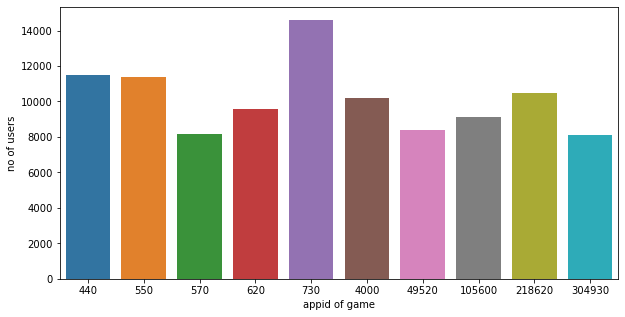

In [5]:
plt.figure(figsize=(10,5))
sns.barplot(x = top_50_games.index, y = top_50_games, orient='v')
plt.xlabel('appid of game')
plt.ylabel('no of users')
plt.show()

### Most played users for top 10 games

In [6]:
top_50_user = df[['user','appid','hours_forever']].groupby('appid').max().sort_values(by='hours_forever',ascending=False)[:10]

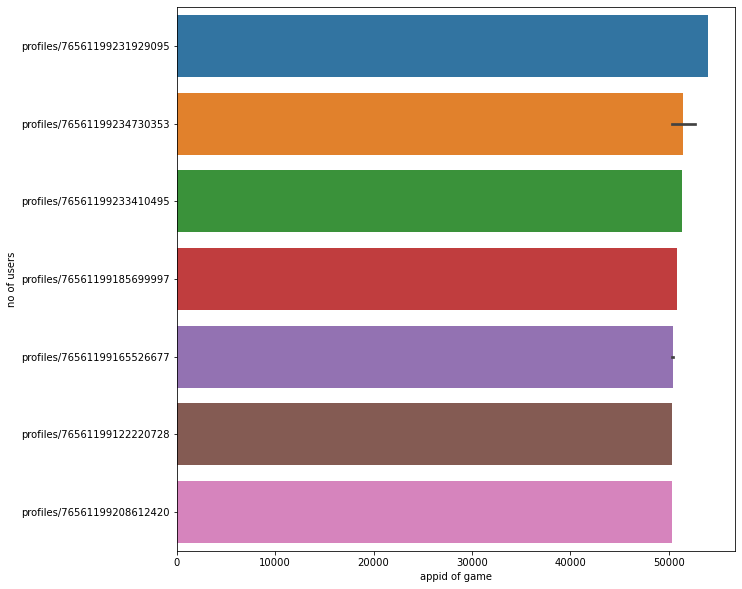

In [7]:
plt.figure(figsize=(10,10))
sns.barplot(y = top_50_user['user'], x = top_50_user['hours_forever'], orient='h')
plt.xlabel('appid of game')
plt.ylabel('no of users')
plt.show()

### Most played users over all games

In [10]:
top_ = df[['user','hours_forever']].sort_values(by='hours_forever',ascending=False)[:10]

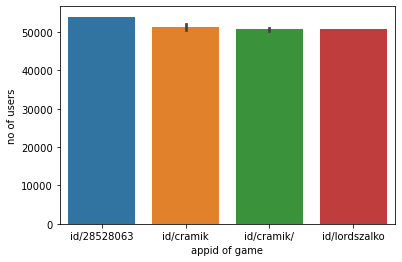

In [11]:
sns.barplot(x = top_.user, y = top_.hours_forever)
plt.xlabel('appid of game')
plt.ylabel('no of users')
plt.show()

### Correlation between 'appid' and 'hoursforever'

In [12]:
df[['appid','hours_forever']].corr()

,appid,hours_forever
appid,1.00000,-0.02799
hours_forever,-0.02799,1.00000
